# Implementing a Markov Chain for Predictive Ranking
In this problem, we use Markov chains to rank $763$ college football teams based on the scores of every game in the $2017$ season.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# The Data
The data is a text file containing $4200$ games, with one game per line in the format:
```
Team A index, Team A points, Team B index, Team B points
```
There are a total of $763$ unique teams.

In [7]:
with open('data/team-names.txt', 'rt') as f:
    teams = f.readlines()
    teams = [team.strip() for team in teams]
    

scores = pd.read_csv('data/cfb2017-scores.csv', header=None)
scores.columns = ['team_a', 'points_a', 'team_b', 'points_b']

# subtract 1 off every single index so indices begin at 0
scores.team_a = scores.team_a - 1
scores.team_b = scores.team_b - 1

print('Number of games: {}'.format(len(scores)))
scores.sample(5)

Number of games: 4200


,team_a,points_a,team_b,points_b
3688,57,45,403,14
312,449,31,563,20
1184,641,27,276,24
731,536,7,2,62
131,435,12,663,10


# Markov Chains
A discrete Markov chain is a sequence of random values $s_1, s_2, s_3, ...$ where the discrete probability distribution of $s_t$ depends only on the state of $s_{t-1}$. That is:

$$p(s_t \mid s_1, s_2, ..., s_{t-1}) = p(s_t \mid s_{t-1})$$

Because each $s \in \{1, ..., S\}$ can take on only $S$ possible states, the relationship between $s_t$ and $s_{t-1}$ can be encoded in an $S \times S$ transition matrix $M$ where each row of $M$ is a probability vector (i.e. sums to $1$), and:

$$p(s_t = j \mid s_{t-1} = i) = M_{ij}$$

Imagine at step $t$ that we have a probability distribution on which state $s_t$ is in, $p(s_t = i)$. Then:

$$p(s_{t+1} = j) = \sum_{i=1}^{S}p(s_{t+1}=j, s_t = i) = \sum_{i=1}^{S}p(s_{t+1} = j \mid s_{t} = i)p(s_t = i)$$

We can represent the distribution of $s_t$ as a row vector $w_t$ such that $p(s_t = j) = w_t(j)$. Then the above can be vectorized:

$$w_t = w_{t-1}M$$.

Which is a recurrence relation that can be unrolled into:

$$w_t = w_0M^t$$

It can be shown that if $M$ satisfies the property that all states are eventually reachable from any other state and $s_1, s_2, s_3, ...$ does not form a cyclical pattern, then $w_{\infty} = w_{\infty}M$. This stationary distribution, $w_{\infty}$, is what we will use to rank the teams.

# Building the Transition Matrix $M$
In using Markov chains to rank college football teams, we are not actually considering the sequence in which the games were played. Rather, we think of each of the $763$ teams as a possible state for $s_t$ and encode for each team a notion that if team $i$ is very good and $s_t = i$, then $s_{t+1} = i$ is highly probable. We can further extend this so that if team $j$ loses frequently or badly to team $i$, then if $s_{t} = j$, $s_{t+1} = i$ is also relatively probable. We can crudely think of the distribution of states for $s_t$ as the amount of **awesomeness** each team has at time $t$ and the distribution at $s_{\infty}$ to be the stable distribution of awesomeness after which the distribution will no longer change.

We want to construct a Markov chain that encourages flows of awesomeness from teams that lose to teams that win. One specific approach could be the following:
- Flows only occur between teams that play each other
- If Team A beats Team B, there should be a high amount of awesomeness flowing from B to A and a low amount flowing from A to B

More concretely, if we let $\hat{M}$ be a $763 \times 763$ matrix of zeros, $i$ be the index of Team A, and $j$ be the index of Team B, we can encode the notion above this way:
- $\hat{M}_{ii} \leftarrow \hat{M}_{ii} + \mathbb{1}\{\text{Team A wins}\} + \frac{\text{points}_i}{\text{points}_i + \text{points}_j}$
- $\hat{M}_{jj} \leftarrow \hat{M}_{jj} + \mathbb{1}\{\text{Team B wins}\} + \frac{\text{points}_j}{\text{points}_i + \text{points}_j}$
- $\hat{M}_{ij} \leftarrow \hat{M}_{ij} + \mathbb{1}\{\text{Team B wins}\} + \frac{\text{points}_j}{\text{points}_i + \text{points}_j}$
- $\hat{M}_{ji} \leftarrow \hat{M}_{ji} + \mathbb{1}\{\text{Team A wins}\} + \frac{\text{points}_i}{\text{points}_i + \text{points}_j}$

To build the final transition matrix $M$, we simply normalize the rows of $\hat{M}$ so that each row is a valid probability vector.

In [8]:
num_teams = scores.team_a.nunique()
M = np.zeros([num_teams, num_teams])
for index, row in scores.iterrows():
    i = row['team_a']
    j = row['team_b']
    a = row['points_a']
    b = row['points_b']
    M[i][i] += (a > b) + a / (a + b)
    M[j][j] += (a < b) + b / (a + b)
    M[i][j] += (a < b) + b / (a + b)
    M[j][i] += (a > b) + a / (a + b)
    
# normalize each row to sum to 1
M = M / np.sum(M, axis=1, keepdims=True)

# Ranking Teams Iteratively
Let $w_t$ be a row vector representing the distribution of awesomeness at time $t$. Then $w_t = w_{t-1}M \implies w_t = w_0M^t$. We initially set all teams to be equally awesome, so $w_0$ is the uniform distribution. For $t = 10, 100, 1000, 10000$, we rank the teams by sorting in decreasing value according to $w_t$ and displaying the top 25 teams.

In [9]:
w_0 = np.ones(num_teams).reshape(1, -1) / num_teams
for t in [10, 100, 1000, 10000]:
    M_t = np.linalg.matrix_power(M, t)
    w_t = w_0.dot(M_t)
    
    df = pd.DataFrame(dict(team=teams, proba=w_t.squeeze()))
    print('{:=^32}'.format('  t={}  '.format(t)))
    print(df[['team', 'proba']] \
          .sort_values(by = 'proba', ascending=False) \
          .head(25))
    print()
    print()

============  t=10  ============
                  team     proba
436         MountUnion  0.018356
371  MaryHardin-Baylor  0.012997
600        StFrancisIN  0.011045
670         UW-Oshkosh  0.009959
622      TAMU-Commerce  0.009295
84         BrockportSt  0.009169
466      NorthDakotaSt  0.009008
5              Alabama  0.008994
433        Morningside  0.008794
241            Georgia  0.008380
301       JamesMadison  0.008076
174     DelawareValley  0.007939
704           Wartburg  0.007579
291          IndianaPA  0.007222
134            Clemson  0.007081
402     MinnSt-Mankato  0.006955
111     CentralFlorida  0.006753
490          OhioState  0.006671
754          Wisconsin  0.006636
527          Reinhardt  0.006580
609           StThomas  0.006016
493           Oklahoma  0.005948
232        FrostburgSt  0.005506
35             Ashland  0.005368
36          Assumption  0.005324


===========  t=100  ============
                   team     proba
436          MountUnion  0.065705
5     

# Calculating the Stationary Distribution 

Given that $M$ satisfies certain properties, $w_{\infty} = w_{\infty}M$. This implies that $M^Tw_{\infty}^T = w_{\infty}^T$, or equivalently $w_{\infty}^T$ is an eigenvector of $M^T$ corresponding to eigenvalue $\lambda = 1$. This property can then be used to quickly calculate the stationary distribution $w_{\infty}$.

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(M.T)

# select eigenvector corresponding to eigenvalue of 1
w_inf = eigenvectors[:,np.argmax(eigenvalues)].astype(float)

# normalize entries to create valid probability vector
w_inf = w_inf / w_inf.sum()

/Users/derekzhao/anaconda3/envs/python-36/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [11]:
M_t = M.copy()
l1_list = list()
t_range = range(1, 10001)
for t in t_range:
    w_t = w_0.dot(M_t)
    M_t = M_t.dot(M)
    l1_list.append(np.abs(w_t - w_10000).sum())

Below, we plot $\left\|w_t - w_{\infty}\right\|_1$ for $t = 1, ..., 10000$ to show this convergence property.

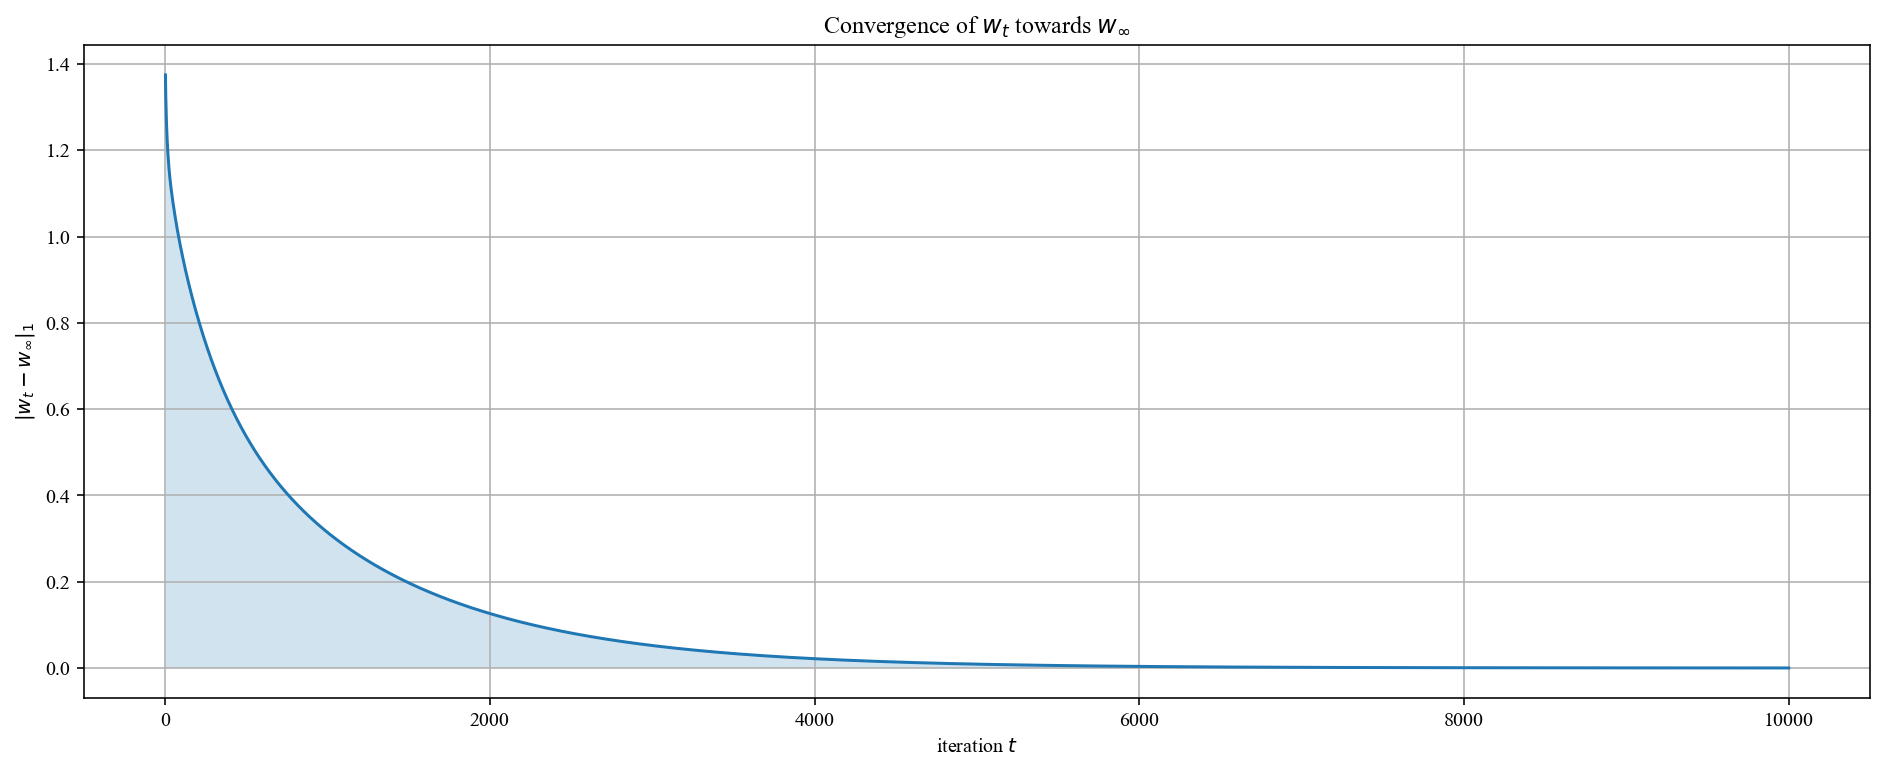

In [12]:
plt.figure(figsize=(16,6))
plt.fill_between(t_range, 0, l1_list, alpha=0.2)
plt.plot(t_range, l1_list)
ax = plt.gca()
ax.set(xlabel='iteration $t$',
       ylabel = '$\\left\\|w_t-w_{\\infty}\\right\\|_1$',
       title = 'Convergence of $w_t$ towards $w_{\infty}$')
ax.grid(True)

Finally, we use $w_{\infty}$ to rank the teams once more, though the results are not much different from $w_{10000}$.

In [15]:
df = pd.DataFrame(dict(team=teams, proba=w_inf.squeeze()))
print('{:=^32}'.format('  t={}  '.format('inf')))
print(df[['team', 'proba']] \
      .sort_values(by = 'proba', ascending=False) \
      .head(25))
print()
print()

===========  t=inf  ============
                team     proba
5            Alabama  0.051796
241          Georgia  0.042739
490        OhioState  0.034011
134          Clemson  0.032928
493         Oklahoma  0.032076
754        Wisconsin  0.031505
111   CentralFlorida  0.029194
37            Auburn  0.026859
507        PennState  0.024350
483        NotreDame  0.018290
624              TCU  0.017442
388          MiamiFL  0.014569
391       MichiganSt  0.014430
495       OklahomaSt  0.013818
294             Iowa  0.013085
477     Northwestern  0.012672
295           IowaSt  0.012535
323              LSU  0.011719
582      SouthernCal  0.011591
707       Washington  0.011340
466    NorthDakotaSt  0.011085
612         Stanford  0.010690
412    MississippiSt  0.010455
693     VirginiaTech  0.010194
462  NorthCarolinaSt  0.009723


